# Step 4 and 5 - Obtaining colors, making diagrams and plotting the galaxies over the SSPs

Make a program (or use a ready-made routine e.g. Pyphot http://mfouesneau.github.io/docs/pyphot/) and integrate the filters (obtain magnitudes and colors) of SDSS in the SSPs and in the galaxies. Make use of these to determine the dominant age in light in the spectra of galaxies.

First of all, let us import some useful packages.

In [1]:
import numpy as np
import matplotlib.ticker
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import glob
from scipy import interpolate
from scipy.special import erf
import pyphot

### Opening the files

Now, let us open the galaxies flux files and save them into a dataframe.

In [2]:
################################################################
### OPENING THE FILES AND SAVING THEIR DATA INTO A DATAFRAME ###
#List with the directories of all galSpecs files:
globbed_files_gal = sorted(glob.glob("galSpecs/*.txt"))

#List for saving the dataframes containing the flux data of each file:
data_gal = []    

for txt in globbed_files_gal:
    #Reading each file and saving the filename in the dataframe as a new column.
    frame_gal = pd.read_csv(txt, delim_whitespace=True, header=None, engine="python")
    frame_gal['filename'] = os.path.basename(txt)  
    
    #Putting the dataframe in the list.
    data_gal.append(frame_gal)

#Concatenating the dataframes of all files.
bigframe_gal = pd.concat(data_gal, ignore_index=True)    

#Changing columns names.
bigframe_gal.columns = ["wavelength", "flux", "filename"]   

#Ensuring that wavelength and flux values will come as float.
bigframe_gal['wavelength'] = bigframe_gal['wavelength'].astype(float)
bigframe_gal['flux'] = bigframe_gal['flux'].astype(float)


############################################
### GROUPING THE DATAFRAME BY "FILENAME" ###
groups_gal = bigframe_gal.groupby('filename')
#If you want to get some specific group, this is the way:
#group0_gal = groups_gal.get_group(globbed_files_gal[0].replace("galSpecs/",""))

print(bigframe_gal.head())
print('\n')
print(bigframe_gal.tail())

   wavelength  flux             filename
0      1000.0   0.0  0289-51990-0627.txt
1      1001.0   0.0  0289-51990-0627.txt
2      1002.0   0.0  0289-51990-0627.txt
3      1003.0   0.0  0289-51990-0627.txt
4      1004.0   0.0  0289-51990-0627.txt


        wavelength  flux             filename
180495     10495.0   0.0  1706-53442-0525.txt
180496     10496.0   0.0  1706-53442-0525.txt
180497     10497.0   0.0  1706-53442-0525.txt
180498     10498.0   0.0  1706-53442-0525.txt
180499     10499.0   0.0  1706-53442-0525.txt


Now, let us open the SSPs flux files and save them into a dataframe.

In [3]:
################################################################
### OPENING THE FILES AND SAVING THEIR DATA INTO A DATAFRAME ###
#List with the directories of all ssps files:
globbed_files_ssps = sorted(glob.glob("ssps/*.spec"))  

#List for saving the dataframes containing the flux data of each file:
data_ssps = []  

for txt in globbed_files_ssps:
    #Reading each file and saving the filename in the dataframe as a new column.
    frame_ssps = pd.read_csv(txt, skiprows=[i for i in range(0,6)], delim_whitespace=True, header=None, engine="python")
    frame_ssps['filename'] = os.path.basename(txt)
    
    #Reading the files again and saving the age in the dataframe as a new column.
    ssp_age = pd.read_csv(txt, delim_whitespace=True, header=None, engine="python")
    frame_ssps['age'] = ssp_age.iloc[4,3]
    
    #Putting the dataframe in the list.
    data_ssps.append(frame_ssps)

#Concatenating the dataframes of all files.
bigframe_ssps = pd.concat(data_ssps, ignore_index=True)    

#Changing columns names.
bigframe_ssps.columns = ["wavelength", "flux", "filename", "age"]

#Ensuring that wavelength, flux and age values will come as float.
bigframe_ssps['wavelength'] = bigframe_ssps['wavelength'].astype(float)
bigframe_ssps['flux'] = bigframe_ssps['flux'].astype(float)
bigframe_ssps['age'] = bigframe_ssps['age'].astype(float)


############################################
### GROUPING THE DATAFRAME BY "FILENAME" ###
groups_ssps = bigframe_ssps.groupby('filename')
#If you want to get some specific group, this is the way:
#group0_ssps = groups_ssps.get_group(globbed_files_ssps[0].replace("ssps/",""))

print(bigframe_ssps.head())
print('\n')
print(bigframe_ssps.tail())

   wavelength          flux        filename       age
0        91.0  9.084000e-08  m22ssp005.spec  177800.0
1        94.0  1.933000e-07  m22ssp005.spec  177800.0
2        96.0  3.108000e-07  m22ssp005.spec  177800.0
3        98.0  4.892000e-07  m22ssp005.spec  177800.0
4       100.0  7.548000e-07  m22ssp005.spec  177800.0


         wavelength          flux        filename           age
1821595    800000.0  3.793000e-12  m72ssp220.spec  1.975000e+10
1821596   1000000.0  1.559000e-12  m72ssp220.spec  1.975000e+10
1821597   1200000.0  7.535000e-13  m72ssp220.spec  1.975000e+10
1821598   1400000.0  4.072000e-13  m72ssp220.spec  1.975000e+10
1821599   1600000.0  2.389000e-13  m72ssp220.spec  1.975000e+10


Now, let us save the ssps filenames in a txt file (this is useful for using PACCE).

In [4]:
#Saving the ssps filenames in ssps_order.txt
ssps_order = [s.replace("ssps/","") for s in globbed_files_ssps]

with open('ssps_order.txt', 'w') as f:
    for item in ssps_order:
        f.write("%s\n" % item)

### Integrating the SDSS filters in the SSPs using Pyphot

The Bruzual and Charlot SSPs spectra has units of $\frac{L_\bigodot}{\angstrom}$ (this is luminosity!). The SSP models are also normalized to a total mass of $1 M_\bigodot$ in stars at age t = 0. http://www.bruzual.org/bc03/doc/bc03.pdf

For using pyphot, I will consider the flux the source would have if it was $10pc$ away from us (distance for computing absolute magnitudes). Having some measure of luminosity in $\frac{L_{\bigodot}}{\angstrom}$, we can obtain the flux in $\frac{erg}{s\times cm^2 \times \angstrom}$ just multiplying by $3.2 \times 10^{-7}$. This comes from the relation $f = \frac{L}{4\pi d_L^2}$, where $d_L$ is the luminosity distance (the same of the proper distance for very small redshifts).

So, let us do it.

In [5]:
#Calling the pyphot library.
lib = pyphot.get_library()

#Defining some arrays to save the magnitudes.
mag_u_ssps = np.zeros(len(globbed_files_ssps))
mag_g_ssps = np.zeros(len(globbed_files_ssps))
mag_r_ssps = np.zeros(len(globbed_files_ssps))
mag_i_ssps = np.zeros(len(globbed_files_ssps))
mag_z_ssps = np.zeros(len(globbed_files_ssps))

#Defining an array to save the age.
age_ssps = np.zeros(len(globbed_files_ssps))

#Computing and saving the magnitudes with pyphot.
j=0
for i in range(0, len(groups_ssps)):
    #Taking the data of just one SSP file.
    single_group =  groups_ssps.get_group(globbed_files_ssps[j].replace("ssps/",""))
    
    #Defining the wavelength and flux from this data.
    wave = single_group.loc[:, 'wavelength'].to_numpy() #Angstrom
    flux = single_group.loc[:, 'flux'].to_numpy()*3.2e-7 #erg/s/cm**2/AA
    
    #Defining wavelength and flux as it will be used in pyphot, considering also the units.
    wave, flux = wave*pyphot.unit['AA'], flux*pyphot.unit['erg/s/cm**2/AA']
    
    #Saving the magnitudes.
    mag_u_ssps[j] = -2.5*np.log10(lib['SDSS_u'].get_flux(wave,flux).value) - lib['SDSS_u'].Vega_zero_mag
    mag_g_ssps[j] = -2.5*np.log10(lib['SDSS_g'].get_flux(wave,flux).value) - lib['SDSS_g'].Vega_zero_mag
    mag_r_ssps[j] = -2.5*np.log10(lib['SDSS_r'].get_flux(wave,flux).value) - lib['SDSS_r'].Vega_zero_mag
    mag_i_ssps[j] = -2.5*np.log10(lib['SDSS_i'].get_flux(wave,flux).value) - lib['SDSS_i'].Vega_zero_mag
    mag_z_ssps[j] = -2.5*np.log10(lib['SDSS_z'].get_flux(wave,flux).value) - lib['SDSS_z'].Vega_zero_mag
    
    #Saving the age.
    age_ssps[j] = single_group.reset_index().loc[0, 'age'] 
    
    j+=1

#Removing the folder name from the directories.
j=0
new_globbed_ssps = []

for i in range(0, len(groups_ssps)):
    new_globbed_ssps.append(globbed_files_ssps[j].replace("ssps/",""))
    j+=1

#Saving into a dataframe.
data_ssps = {'filename': new_globbed_ssps,
             'mag_u': mag_u_ssps,
             'mag_g': mag_g_ssps,
             'mag_r': mag_r_ssps,
             'mag_i': mag_i_ssps,
             'mag_z': mag_z_ssps,
             'age': age_ssps}

df_magnitudes_ssps = pd.DataFrame(data_ssps)

print(df_magnitudes_ssps.head())

         filename     mag_u     mag_g     mag_r     mag_i     mag_z        age
0  m22ssp005.spec -0.016700  1.462779  1.728009  1.852378  2.053462   177800.0
1  m22ssp010.spec -0.027666  1.452018  1.717217  1.841898  2.042812   316200.0
2  m22ssp015.spec -0.018176  1.459973  1.724136  1.848091  2.048707   562300.0
3  m22ssp020.spec -0.054940  1.419106  1.679673  1.803621  2.001382  1000000.0
4  m22ssp025.spec -0.095184  1.385348  1.649270  1.772266  1.977020  1259000.0


Now, I will compute the colors.

In [6]:
all_colors = ['U-G', 'G-R', 'R-I', 'I-Z', 'U-R', 'U-I', 'U-Z', 'G-I', 'G-Z', 'R-Z']

#Sequential colors.
df_magnitudes_ssps['U-G'] = df_magnitudes_ssps['mag_u'] - df_magnitudes_ssps['mag_g']
df_magnitudes_ssps['G-R'] = df_magnitudes_ssps['mag_g'] - df_magnitudes_ssps['mag_r']
df_magnitudes_ssps['R-I'] = df_magnitudes_ssps['mag_r'] - df_magnitudes_ssps['mag_i']
df_magnitudes_ssps['I-Z'] = df_magnitudes_ssps['mag_i'] - df_magnitudes_ssps['mag_z']

#Other colors.
df_magnitudes_ssps['U-R'] = df_magnitudes_ssps['mag_u'] - df_magnitudes_ssps['mag_r']
df_magnitudes_ssps['U-I'] = df_magnitudes_ssps['mag_u'] - df_magnitudes_ssps['mag_i']
df_magnitudes_ssps['U-Z'] = df_magnitudes_ssps['mag_u'] - df_magnitudes_ssps['mag_z']

df_magnitudes_ssps['G-I'] = df_magnitudes_ssps['mag_g'] - df_magnitudes_ssps['mag_i']
df_magnitudes_ssps['G-Z'] = df_magnitudes_ssps['mag_g'] - df_magnitudes_ssps['mag_z']

df_magnitudes_ssps['R-Z'] = df_magnitudes_ssps['mag_r'] - df_magnitudes_ssps['mag_z']

print(df_magnitudes_ssps.head())

         filename     mag_u     mag_g     mag_r     mag_i     mag_z  \
0  m22ssp005.spec -0.016700  1.462779  1.728009  1.852378  2.053462   
1  m22ssp010.spec -0.027666  1.452018  1.717217  1.841898  2.042812   
2  m22ssp015.spec -0.018176  1.459973  1.724136  1.848091  2.048707   
3  m22ssp020.spec -0.054940  1.419106  1.679673  1.803621  2.001382   
4  m22ssp025.spec -0.095184  1.385348  1.649270  1.772266  1.977020   

         age       U-G       G-R       R-I       I-Z       U-R       U-I  \
0   177800.0 -1.479479 -0.265230 -0.124369 -0.201084 -1.744709 -1.869078   
1   316200.0 -1.479684 -0.265199 -0.124681 -0.200914 -1.744883 -1.869564   
2   562300.0 -1.478150 -0.264163 -0.123954 -0.200616 -1.742313 -1.866267   
3  1000000.0 -1.474046 -0.260566 -0.123949 -0.197761 -1.734612 -1.858561   
4  1259000.0 -1.480532 -0.263923 -0.122996 -0.204753 -1.744454 -1.867450   

        U-Z       G-I       G-Z       R-Z  
0 -2.070162 -0.389599 -0.590683 -0.325453  
1 -2.070478 -0.389880 -0.590

Now, I will insert the metallicities, according to http://www.bruzual.org/bc03/doc/bc03.pdf.

In [7]:
number_files_per_model = 44

### m22
df_magnitudes_ssps.loc[(0*number_files_per_model):(1*number_files_per_model-1), '[Fe/H]'] = -2.2490
### m32
df_magnitudes_ssps.loc[(1*number_files_per_model):(2*number_files_per_model-1), '[Fe/H]'] = -1.6464
### m42
df_magnitudes_ssps.loc[(2*number_files_per_model):(3*number_files_per_model-1), '[Fe/H]'] = -0.6392
### m52
df_magnitudes_ssps.loc[(3*number_files_per_model):(4*number_files_per_model-1), '[Fe/H]'] = -0.3300
### m62
df_magnitudes_ssps.loc[(4*number_files_per_model):(5*number_files_per_model-1), '[Fe/H]'] = 0.0932
### m72
df_magnitudes_ssps.loc[(5*number_files_per_model):(6*number_files_per_model-1), '[Fe/H]'] = 0.5595

print(df_magnitudes_ssps.head())

         filename     mag_u     mag_g     mag_r     mag_i     mag_z  \
0  m22ssp005.spec -0.016700  1.462779  1.728009  1.852378  2.053462   
1  m22ssp010.spec -0.027666  1.452018  1.717217  1.841898  2.042812   
2  m22ssp015.spec -0.018176  1.459973  1.724136  1.848091  2.048707   
3  m22ssp020.spec -0.054940  1.419106  1.679673  1.803621  2.001382   
4  m22ssp025.spec -0.095184  1.385348  1.649270  1.772266  1.977020   

         age       U-G       G-R       R-I       I-Z       U-R       U-I  \
0   177800.0 -1.479479 -0.265230 -0.124369 -0.201084 -1.744709 -1.869078   
1   316200.0 -1.479684 -0.265199 -0.124681 -0.200914 -1.744883 -1.869564   
2   562300.0 -1.478150 -0.264163 -0.123954 -0.200616 -1.742313 -1.866267   
3  1000000.0 -1.474046 -0.260566 -0.123949 -0.197761 -1.734612 -1.858561   
4  1259000.0 -1.480532 -0.263923 -0.122996 -0.204753 -1.744454 -1.867450   

        U-Z       G-I       G-Z       R-Z  [Fe/H]  
0 -2.070162 -0.389599 -0.590683 -0.325453  -2.249  
1 -2.070478 

### Integrating the SDSS filters in the galSpecs using Pyphot

Now, I will do the same thing to the galSpecs, considering that they are given also in units of luminosity (so, I will multiply the flux by the before mentioned factor).

In [8]:
#Calling the pyphot library.
lib = pyphot.get_library()

#Defining some arrays to save the magnitudes.
mag_u_gal = np.zeros(len(globbed_files_gal))
mag_g_gal = np.zeros(len(globbed_files_gal))
mag_r_gal = np.zeros(len(globbed_files_gal))
mag_i_gal = np.zeros(len(globbed_files_gal))
mag_z_gal = np.zeros(len(globbed_files_gal))

#Computing and saving the magnitudes with pyphot.
j=0
for i in range(0, len(groups_gal)):
    #Taking the data of just one galSpec file.
    single_group =  groups_gal.get_group(globbed_files_gal[j].replace("galSpecs/",""))
    
    #Defining the wavelength and flux from this data.
    wave = single_group.loc[:, 'wavelength'].to_numpy() #Angstrom
    flux = single_group.loc[:, 'flux'].to_numpy()*3.2e-7 #erg/s/cm**2/AA
    
    #Defining wavelength and flux as it will be used in pyphot, considering also the units.
    wave, flux = wave*pyphot.unit['AA'], flux*pyphot.unit['erg/s/cm**2/AA']
    
    #Saving the magnitudes.
    mag_u_gal[j] = -2.5*np.log10(lib['SDSS_u'].get_flux(wave,flux).value) - lib['SDSS_u'].Vega_zero_mag
    mag_g_gal[j] = -2.5*np.log10(lib['SDSS_g'].get_flux(wave,flux).value) - lib['SDSS_g'].Vega_zero_mag
    mag_r_gal[j] = -2.5*np.log10(lib['SDSS_r'].get_flux(wave,flux).value) - lib['SDSS_r'].Vega_zero_mag
    mag_i_gal[j] = -2.5*np.log10(lib['SDSS_i'].get_flux(wave,flux).value) - lib['SDSS_i'].Vega_zero_mag
    mag_z_gal[j] = -2.5*np.log10(lib['SDSS_z'].get_flux(wave,flux).value) - lib['SDSS_z'].Vega_zero_mag
    
    j+=1

#Removing the folder name from the directories.
j=0
new_globbed_gal = []

for i in range(0, len(groups_gal)):
    new_globbed_gal.append(globbed_files_gal[j].replace("galSpecs/",""))
    j+=1

#Saving into a dataframe.
data_gal = {'filename': new_globbed_gal,
             'mag_u': mag_u_gal,
             'mag_g': mag_g_gal,
             'mag_r': mag_r_gal,
             'mag_i': mag_i_gal,
             'mag_z': mag_z_gal}

df_magnitudes_gal = pd.DataFrame(data_gal)

print(df_magnitudes_gal.head())

              filename     mag_u      mag_g      mag_r      mag_i      mag_z
0  0289-51990-0627.txt -5.573072  -7.417299  -8.023690  -8.063816  -8.000798
1  0307-51663-0068.txt -7.670950 -10.275932 -11.636184 -12.367606 -12.544775
2  0310-51990-0445.txt -8.388223 -11.131515 -12.225239 -12.850163 -12.936461
3  0441-51868-0303.txt -7.659129  -9.732634 -10.398495 -10.757152 -10.735843
4  0463-51908-0117.txt -8.622731 -10.276411 -11.355568 -11.949403 -11.747975


Now, I will compute the colors.

In [9]:
#Sequential colors.
df_magnitudes_gal['U-G'] = df_magnitudes_gal['mag_u'] - df_magnitudes_gal['mag_g']
df_magnitudes_gal['G-R'] = df_magnitudes_gal['mag_g'] - df_magnitudes_gal['mag_r']
df_magnitudes_gal['R-I'] = df_magnitudes_gal['mag_r'] - df_magnitudes_gal['mag_i']
df_magnitudes_gal['I-Z'] = df_magnitudes_gal['mag_i'] - df_magnitudes_gal['mag_z']

#Other colors.
df_magnitudes_gal['U-R'] = df_magnitudes_gal['mag_u'] - df_magnitudes_gal['mag_r']
df_magnitudes_gal['U-I'] = df_magnitudes_gal['mag_u'] - df_magnitudes_gal['mag_i']
df_magnitudes_gal['U-Z'] = df_magnitudes_gal['mag_u'] - df_magnitudes_gal['mag_z']

df_magnitudes_gal['G-I'] = df_magnitudes_gal['mag_g'] - df_magnitudes_gal['mag_i']
df_magnitudes_gal['G-Z'] = df_magnitudes_gal['mag_g'] - df_magnitudes_gal['mag_z']

df_magnitudes_gal['R-Z'] = df_magnitudes_gal['mag_r'] - df_magnitudes_gal['mag_z']

print(df_magnitudes_gal.head())

              filename     mag_u      mag_g      mag_r      mag_i      mag_z  \
0  0289-51990-0627.txt -5.573072  -7.417299  -8.023690  -8.063816  -8.000798   
1  0307-51663-0068.txt -7.670950 -10.275932 -11.636184 -12.367606 -12.544775   
2  0310-51990-0445.txt -8.388223 -11.131515 -12.225239 -12.850163 -12.936461   
3  0441-51868-0303.txt -7.659129  -9.732634 -10.398495 -10.757152 -10.735843   
4  0463-51908-0117.txt -8.622731 -10.276411 -11.355568 -11.949403 -11.747975   

        U-G       G-R       R-I       I-Z       U-R       U-I       U-Z  \
0  1.844227  0.606392  0.040126 -0.063018  2.450618  2.490744  2.427726   
1  2.604982  1.360252  0.731422  0.177168  3.965234  4.696657  4.873825   
2  2.743292  1.093724  0.624924  0.086299  3.837016  4.461940  4.548238   
3  2.073505  0.665861  0.358657 -0.021309  2.739367  3.098023  3.076714   
4  1.653680  1.079157  0.593836 -0.201428  2.732837  3.326672  3.125244   

        G-I       G-Z       R-Z  
0  0.646517  0.583499 -0.022892  


## PLOT ATTEMPTS

First, let us list some definitions before all plots.

In [10]:
###############################################################################
########################### SOME DEFINITIONS BEFORE PLOTS ######################

### Grouping ssps by metallicities:
groups = df_magnitudes_ssps.groupby('[Fe/H]')     #Grouping the elements.
groups_list = list(groups.groups)                 #Listing the groups indices.

### Grouping ssps by ages:
groups2 = df_magnitudes_ssps.groupby('age')       #Grouping the elements.
groups2_list = list(groups2.groups)               #Listing the groups indices.

### Defining the colors:
colors = ['#eb0202','#ebbc02', '#54eb02', '#02ebcc', '#0602eb', '#eb02e7']
colors2 = ['#609E54', '#EC95AC','#FF00F0', '#737373', '#048700', '#eb0202', '#eb7302', '#54eb02', '#02ebcc',  
           '#ebbc02', '#02a1eb', '#0602eb','#5b02eb', '#eb02e7', '#000000', '#aba563', '#de9a80']

### Plotting the color-color diagrams with ages.

First, let us plot the low age part of the diagram.

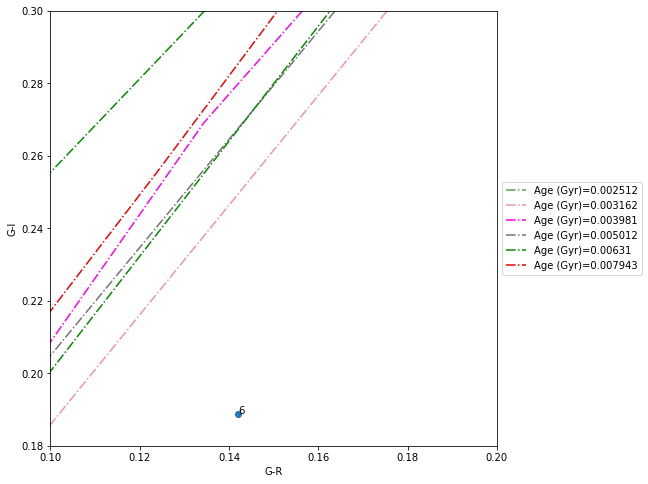

In [11]:
### Defining a list of ages for making the diagram.
groups2_list_limited = [i for i in groups2_list if (i>=2512000.0) & (i < 10000000.0)]

### Defining an age limit for plotting.
age_lim_min = min(groups2_list_limited)
age_lim_max = max(groups2_list_limited)

### Colors to plot
x_color = 'G-R'
y_color = 'G-I'

### Making the plot.
fig = plt.figure(figsize=(8, 8))   #Defining figure. 
ax = plt.subplot()                 #Defining ax.

### Plotting the lines of constant metallicity.
#j=0
#for i in groups_list:
#    grouping = groups.get_group(i)[(groups.get_group(i)['age']>=age_lim_min) & (groups.get_group(i)['age']<age_lim_max)]
#    x = grouping[x_color]
#    y = grouping[y_color]
#    ax.plot(x, y, color=colors[j], linestyle='dashed', label='[Fe/H]='+str(i))
#    j+=1

### Plotting the lines of constant age.
j=0
for i in groups2_list_limited:
    grouping2 = groups2.get_group(i)
    x = grouping2[x_color]
    y = grouping2[y_color]
    ax.plot(x, y, color=colors2[j], linestyle='dashdot', label='Age (Gyr)='+str(i/(1e9)))
    j+=1

##################################################################
### Plotting the GALAXIES over the grid.
x_galpoints = df_magnitudes_gal[x_color]
y_galpoints = df_magnitudes_gal[y_color]

ax.scatter(x_galpoints, y_galpoints)

#Annotating the points numbers.
n = df_magnitudes_gal.index.to_list()

for i, txt in enumerate(n):
    ax.annotate(txt, (x_galpoints[i], y_galpoints[i]))
##################################################################

### Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Setting the axis limits.
ax.set_xlim(left=0.1, right=0.2)
ax.set_ylim(bottom=0.18, top=0.30)

### Setting the axis labels.
ax.set_xlabel(x_color)
ax.set_ylabel(y_color)

plt.show()

Plotting the middle age - Part 1

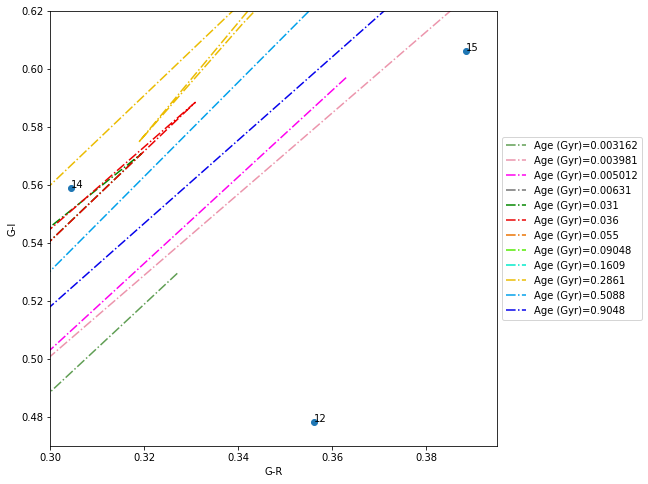

In [12]:
#### Defining a list of ages for making the diagram.
middle_age_1 = [3162000.0, 3981000.0, 5012000.0, 6310000.0, 31000000.0, 36000000.0, 55000000.0,
                 90480000.0, 160900000.0, 286100000.0, 508800000.0, 904800000.0] 

groups2_list_limited = middle_age_1

### Defining an age limit for plotting.
age_lim_min = min(groups2_list_limited)
age_lim_max = max(groups2_list_limited)

### Colors to plot
x_color = 'G-R'
y_color = 'G-I'

### Making the plot.
fig = plt.figure(figsize=(8, 8))   #Defining figure. 
ax = plt.subplot()                 #Defining ax.

### Plotting the lines of constant metallicity.
#j=0
#for i in groups_list:
#    grouping = groups.get_group(i)[(groups.get_group(i)['age']>=age_lim_min) & (groups.get_group(i)['age']<age_lim_max)]
#    x = grouping[x_color]
#    y = grouping[y_color]
#    ax.plot(x, y, color=colors[j], linestyle='dashed', label='[Fe/H]='+str(i))
#    j+=1

### Plotting the lines of constant age.
j=0
for i in groups2_list_limited:
    grouping2 = groups2.get_group(i)
    x = grouping2[x_color]
    y = grouping2[y_color]
    ax.plot(x, y, color=colors2[j], linestyle='dashdot', label='Age (Gyr)='+str(i/(1e9)))
    j+=1

##################################################################
### Plotting the GALAXIES over the grid.
x_galpoints = df_magnitudes_gal[x_color]
y_galpoints = df_magnitudes_gal[y_color]

ax.scatter(x_galpoints, y_galpoints)

#Annotating the points numbers.
n = df_magnitudes_gal.index.to_list()

for i, txt in enumerate(n):
    ax.annotate(txt, (x_galpoints[i], y_galpoints[i]))
##################################################################

### Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Setting the axis limits.
ax.set_xlim(left=0.3, right=0.395)
ax.set_ylim(bottom=0.47, top=0.62)

### Setting the axis labels.
ax.set_xlabel(x_color)
ax.set_ylabel(y_color)

plt.show()

Plotting the middle age - Part 2

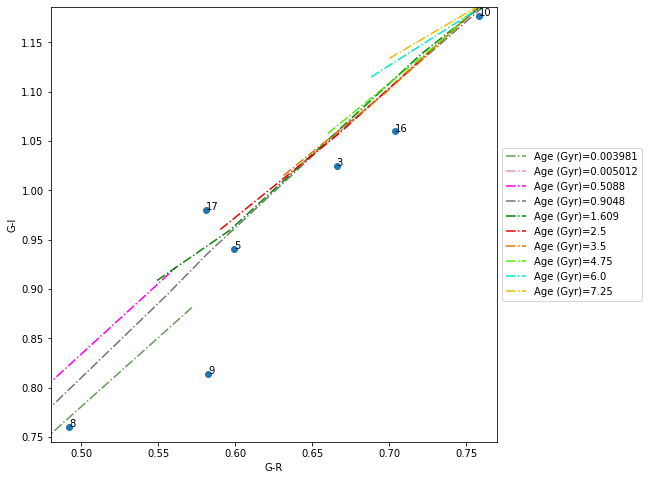

In [13]:
#### Defining a list of ages for making the diagram.
middle_age_1 = [3981000.0, 5012000.0, 508800000.0, 904800000.0, 1609000000.0, 2500000000.0,
                3500000000.0, 4750000000.0, 6000000000.0, 7250000000.0]  

groups2_list_limited = middle_age_1

### Defining an age limit for plotting.
age_lim_min = min(groups2_list_limited)
age_lim_max = max(groups2_list_limited)

### Colors to plot
x_color = 'G-R'
y_color = 'G-I'

### Making the plot.
fig = plt.figure(figsize=(8, 8))   #Defining figure. 
ax = plt.subplot()                 #Defining ax.

### Plotting the lines of constant metallicity.
#j=0
#for i in groups_list:
#    grouping = groups.get_group(i)[(groups.get_group(i)['age']>=age_lim_min) & (groups.get_group(i)['age']<age_lim_max)]
#    x = grouping[x_color]
#    y = grouping[y_color]
#    ax.plot(x, y, color=colors[j], linestyle='dashed', label='[Fe/H]='+str(i))
#    j+=1

### Plotting the lines of constant age.
j=0
for i in groups2_list_limited:
    grouping2 = groups2.get_group(i)
    x = grouping2[x_color]
    y = grouping2[y_color]
    ax.plot(x, y, color=colors2[j], linestyle='dashdot', label='Age (Gyr)='+str(i/(1e9)))
    j+=1

##################################################################
### Plotting the GALAXIES over the grid.
x_galpoints = df_magnitudes_gal[x_color]
y_galpoints = df_magnitudes_gal[y_color]

ax.scatter(x_galpoints, y_galpoints)

#Annotating the points numbers.
n = df_magnitudes_gal.index.to_list()

for i, txt in enumerate(n):
    ax.annotate(txt, (x_galpoints[i], y_galpoints[i]))
##################################################################

### Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Setting the axis limits.
ax.set_xlim(left=0.48, right=0.77)
ax.set_ylim(bottom=0.745, top=1.186)

### Setting the axis labels.
ax.set_xlabel(x_color)
ax.set_ylabel(y_color)

plt.show()

Plotting the high age.

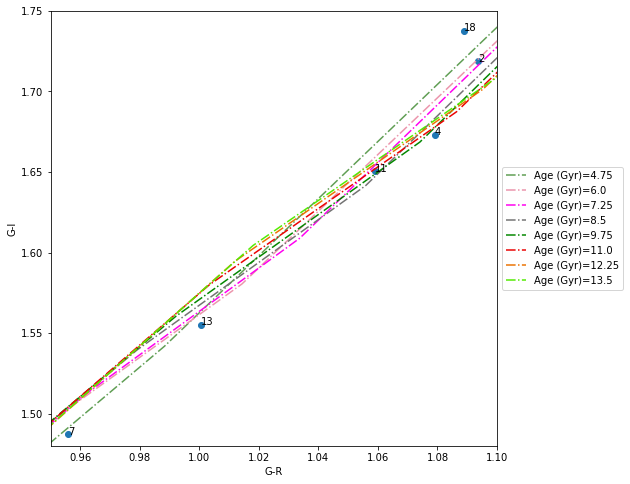

In [14]:
### Defining a list of ages for making the diagram.
groups2_list_limited = [i for i in groups2_list if (i>=4750000000.0) & (i < 14750000000.0)]

### Defining an age limit for plotting.
age_lim_min = min(groups2_list_limited)
age_lim_max = max(groups2_list_limited)

### Colors to plot
x_color = 'G-R'
y_color = 'G-I'

### Making the plot.
fig = plt.figure(figsize=(8, 8))   #Defining figure. 
ax = plt.subplot()                 #Defining ax.

### Plotting the lines of constant metallicity.
#j=0
#for i in groups_list:
#    grouping = groups.get_group(i)[(groups.get_group(i)['age']>=age_lim_min) & (groups.get_group(i)['age']<age_lim_max)]
#    x = grouping[x_color]
#    y = grouping[y_color]
#    ax.plot(x, y, color=colors[j], linestyle='dashed', label='[Fe/H]='+str(i))
#    j+=1

### Plotting the lines of constant age.
j=0
for i in groups2_list_limited:
    grouping2 = groups2.get_group(i)
    x = grouping2[x_color]
    y = grouping2[y_color]
    ax.plot(x, y, color=colors2[j], linestyle='dashdot', label='Age (Gyr)='+str(i/(1e9)))
    j+=1

##################################################################
### Plotting the GALAXIES over the grid.
x_galpoints = df_magnitudes_gal[x_color]
y_galpoints = df_magnitudes_gal[y_color]

ax.scatter(x_galpoints, y_galpoints)

#Annotating the points numbers.
n = df_magnitudes_gal.index.to_list()

for i, txt in enumerate(n):
    ax.annotate(txt, (x_galpoints[i], y_galpoints[i]))
##################################################################

### Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Setting the axis limits.
ax.set_xlim(left=0.95, right=1.1)
ax.set_ylim(bottom=1.48, top=1.75)

### Setting the axis labels.
ax.set_xlabel(x_color)
ax.set_ylabel(y_color)

plt.show()

Plotting all.

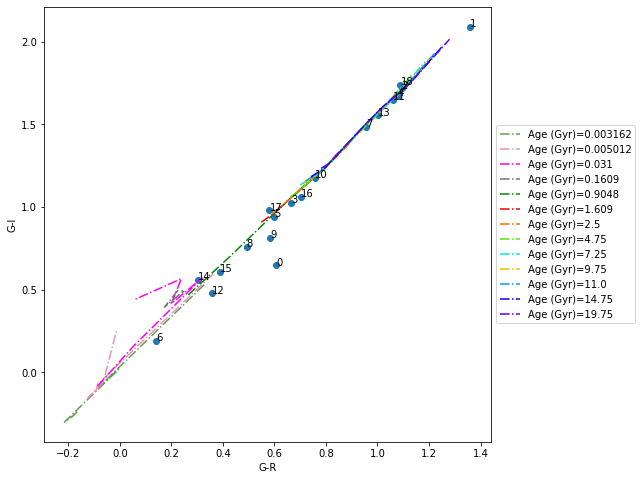

In [15]:
#### Defining a list of ages for making the diagram.
all_ages = [3162000.0, 5012000.0, 31000000.0, 160900000.0,904800000.0, 1609000000.0, 2500000000.0,
            4750000000.0, 7250000000.0, 9750000000.0, 11000000000.0, 14750000000.0, 19750000000.0]  

groups2_list_limited = all_ages

### Defining an age limit for plotting.
age_lim_min = min(groups2_list_limited)
age_lim_max = max(groups2_list_limited)

### Colors to plot
x_color = 'G-R'
y_color = 'G-I'

### Making the plot.
fig = plt.figure(figsize=(8, 8))   #Defining figure. 
ax = plt.subplot()                 #Defining ax.

### Plotting the lines of constant metallicity.
#j=0
#for i in groups_list:
#    grouping = groups.get_group(i)[(groups.get_group(i)['age']>=age_lim_min) & (groups.get_group(i)['age']<age_lim_max)]
#    x = grouping[x_color]
#    y = grouping[y_color]
#    ax.plot(x, y, color=colors[j], linestyle='dashed', label='[Fe/H]='+str(i))
#    j+=1

### Plotting the lines of constant age.
j=0
for i in groups2_list_limited:
    grouping2 = groups2.get_group(i)
    x = grouping2[x_color]
    y = grouping2[y_color]
    ax.plot(x, y, color=colors2[j], linestyle='dashdot', label='Age (Gyr)='+str(i/(1e9)))
    j+=1

##################################################################
### Plotting the GALAXIES over the grid.
x_galpoints = df_magnitudes_gal[x_color]
y_galpoints = df_magnitudes_gal[y_color]

ax.scatter(x_galpoints, y_galpoints)

#Annotating the points numbers.
n = df_magnitudes_gal.index.to_list()

for i, txt in enumerate(n):
    ax.annotate(txt, (x_galpoints[i], y_galpoints[i]))
##################################################################

### Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Setting the axis limits.
#ax.set_xlim(left=0.95, right=1.1)
#ax.set_ylim(bottom=1.48, top=1.75)

### Setting the axis labels.
ax.set_xlabel(x_color)
ax.set_ylabel(y_color)

plt.show()

### Plotting the appropriated SSPs in the galaxies

Some definitions before plot.

In [16]:
###############################################################################
########################### SOME DEFINITIONS BEFORE PLOTS ######################

### Grouping the galaxies by filename.
### Here, I am grouping the bigframe_gal, which contains the fluxes and the wavelengths.
groups_gal = bigframe_gal.groupby('filename')       #Grouping the elements.
groups_gal_list = list(groups_gal.groups)           #Listing the groups indices.

### Grouping the galaxies by filename.
### Here, I am grouping the bigframe_ssps, which contains the fluxes and the wavelengths.
groups_ssps = bigframe_ssps.groupby('filename')       #Grouping the elements.
groups_ssps_list = list(groups_ssps.groups)           #Listing the groups indices.

### Defining the colors:
colors = ['#eb0202','#ebbc02', '#54eb02', '#02ebcc', '#0602eb', '#eb02e7']
colors2 = ['#609E54', '#EC95AC','#FF00F0', '#737373', '#048700', '#eb0202', '#eb7302', '#54eb02', '#02ebcc',  
           '#ebbc02', '#02a1eb', '#0602eb','#5b02eb', '#eb02e7', '#000000', '#aba563', '#de9a80']

Making the plots.

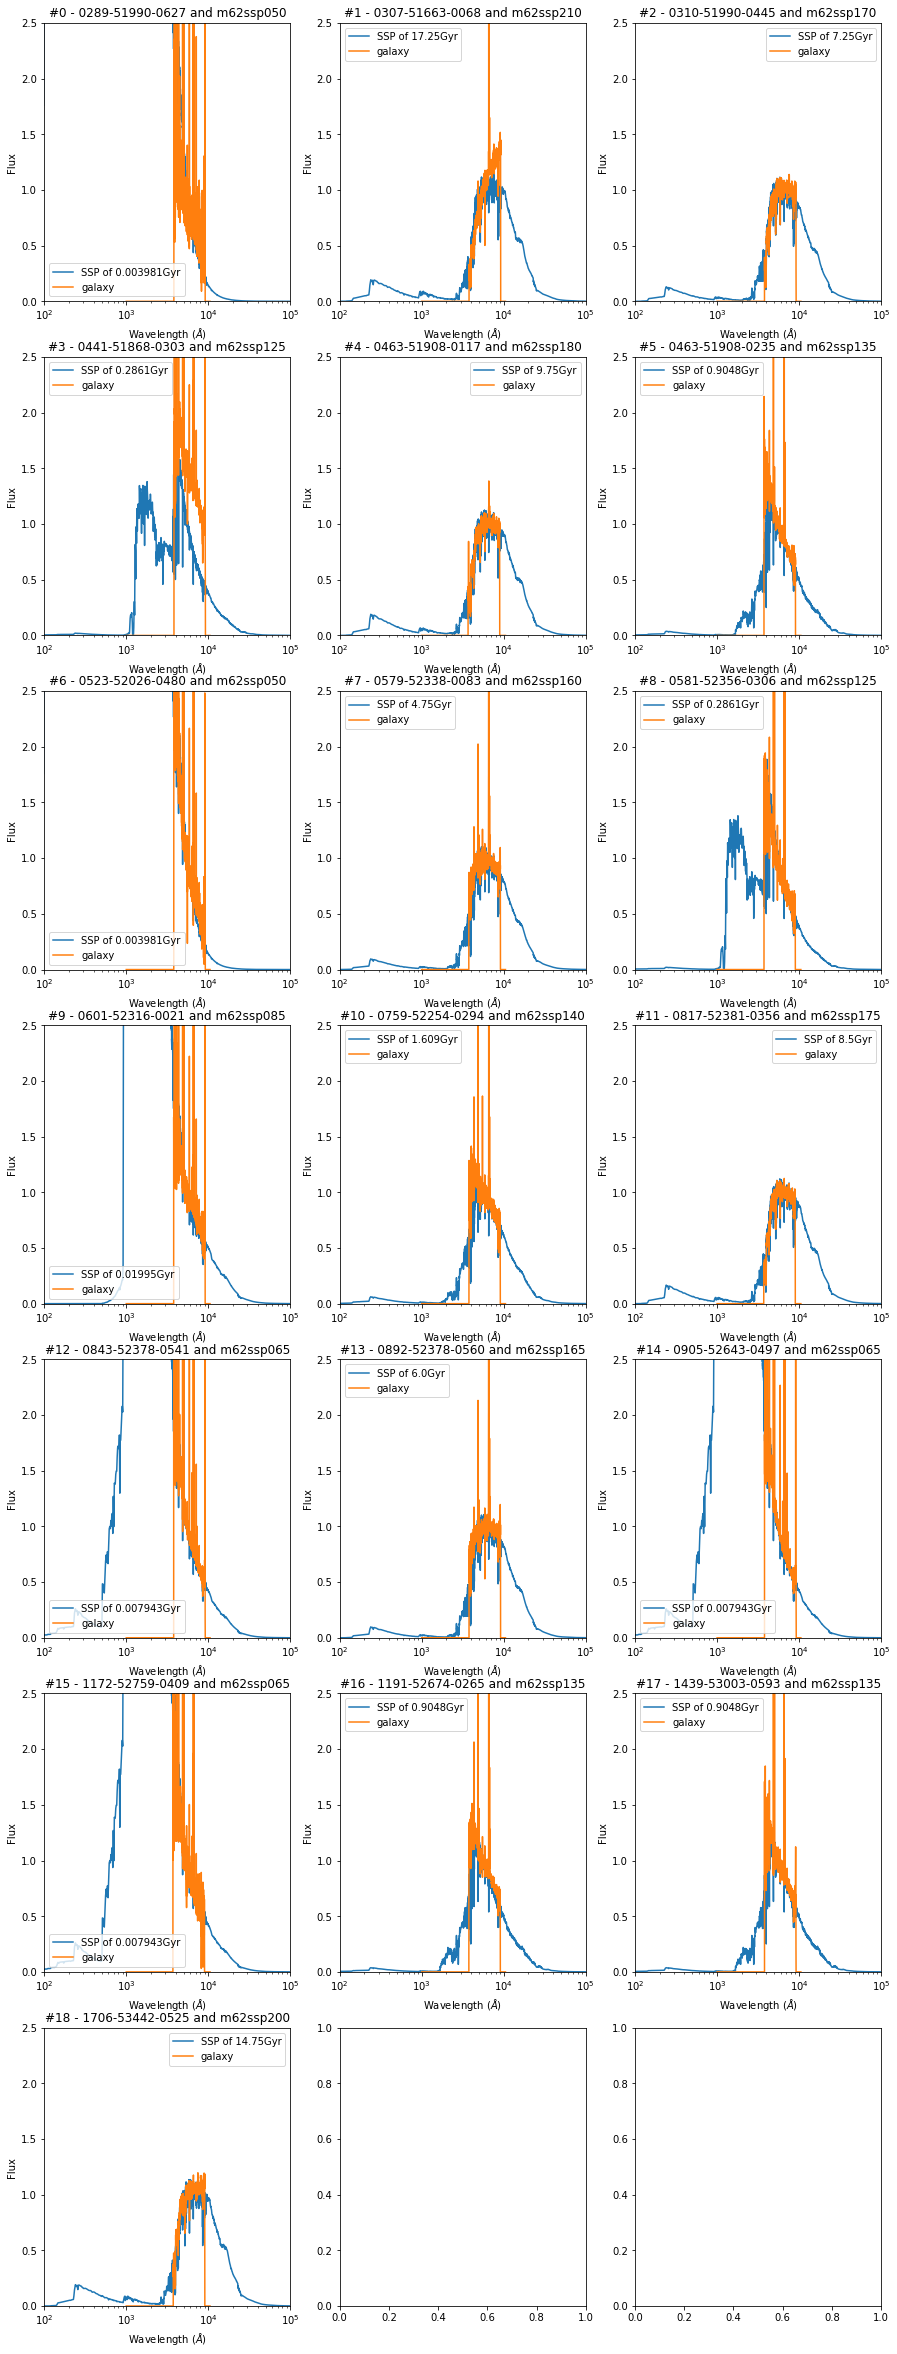

In [21]:
### Defining a list for saving the parameters to plot.
gal_ssps_list = []

### Saving the parameters of each plot.
gal_ssps_list.append([0, '0289-51990-0627.txt', 'm62ssp050.spec', 0, 0]) #number / gal_file / ssp_file / i_ax / j_ax 
gal_ssps_list.append([1, '0307-51663-0068.txt', 'm62ssp210.spec', 0, 1])
gal_ssps_list.append([2, '0310-51990-0445.txt', 'm62ssp170.spec', 0, 2])
gal_ssps_list.append([3, '0441-51868-0303.txt', 'm62ssp125.spec', 1, 0])
gal_ssps_list.append([4, '0463-51908-0117.txt', 'm62ssp180.spec', 1, 1])
gal_ssps_list.append([5, '0463-51908-0235.txt', 'm62ssp135.spec', 1, 2])
gal_ssps_list.append([6, '0523-52026-0480.txt', 'm62ssp050.spec', 2, 0])
gal_ssps_list.append([7, '0579-52338-0083.txt', 'm62ssp160.spec', 2, 1])
gal_ssps_list.append([8, '0581-52356-0306.txt', 'm62ssp125.spec', 2, 2])
gal_ssps_list.append([9, '0601-52316-0021.txt', 'm62ssp085.spec', 3, 0])
gal_ssps_list.append([10, '0759-52254-0294.txt', 'm62ssp140.spec', 3, 1])
gal_ssps_list.append([11, '0817-52381-0356.txt', 'm62ssp175.spec', 3, 2])
gal_ssps_list.append([12, '0843-52378-0541.txt', 'm62ssp065.spec', 4, 0])
gal_ssps_list.append([13, '0892-52378-0560.txt', 'm62ssp165.spec', 4, 1])
gal_ssps_list.append([14, '0905-52643-0497.txt', 'm62ssp065.spec', 4, 2])
gal_ssps_list.append([15, '1172-52759-0409.txt', 'm62ssp065.spec', 5, 0])
gal_ssps_list.append([16, '1191-52674-0265.txt', 'm62ssp135.spec', 5, 1])
gal_ssps_list.append([17, '1439-53003-0593.txt', 'm62ssp135.spec', 5, 2])
gal_ssps_list.append([18, '1706-53442-0525.txt', 'm62ssp200.spec', 6, 0])

### Defining figure and axis.
num_cols = 3
num_rows = (len(gal_ssps_list)-1)//num_cols + 1 
figure, axis = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,6*num_rows))

for number_i in gal_ssps_list:
    ### Defining the parameters of the plot.
    number = number_i[0]
    gal_file = number_i[1]
    ssp_file = number_i[2]
    i_ax =  number_i[3]
    j_ax = number_i[4]
    
    ####### Making the plot ########
    ###### SSP ######
    ssp = groups_ssps.get_group(ssp_file) #1.6 Gyr
    ssp_norm_factor = ssp[(ssp['wavelength'] > 5569) & (ssp['wavelength'] < 5571)]['flux'].to_numpy()[0]

    age = ssp.reset_index().loc[0,'age']
    
    #Plotting the ssp.
    axis[i_ax,j_ax].plot(ssp['wavelength'], ssp['flux']/ssp_norm_factor, label='SSP of '+str(age/1e9)+'Gyr')

    ###### GAL ######
    gal = groups_gal.get_group(gal_file)
    gal_norm_factor = gal[(gal['wavelength'] > 5569) & (gal['wavelength'] < 5571)]['flux'].to_numpy()[0]

    axis[i_ax,j_ax].plot(gal['wavelength'], gal['flux']/gal_norm_factor, label='galaxy')

    ###### AXIS DEF ######
    ### Setting the axis scale.
    axis[i_ax,j_ax].set_xscale('log')

    ### Put a legend to the right of the current axis
    #axis[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axis[i_ax,j_ax].legend()

    ### Setting the axis labels.
    axis[i_ax,j_ax].set_xlabel('Wavelength ($\\AA$)')
    axis[i_ax,j_ax].set_ylabel('Flux')

    ### Setting the title.
    axis[i_ax,j_ax].set_title('#'+str(number)+' - '+gal_file.replace(".txt","")+' and '+ssp_file.replace(".spec",""))

    ### Setting axis limits.
    axis[i_ax,j_ax].set_xlim(left=1e2, right=1e5)
    axis[i_ax,j_ax].set_ylim(bottom=0, top=2.5)
    
plt.show()